In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Simulation

In [12]:
pi1 = 0.6
pi2 = 1 - pi1

lambda1 = 1
lambda2 = 2
theta1 = 2
theta2 = 1

n = 1000

n1 = np.random.binomial(n, pi1, 1)[0]
n2 = n - n1

X1 = np.column_stack(
    (
    np.random.exponential(scale=1/lambda1, size=n1),
    np.random.exponential(scale=1/lambda2, size=n1),
    )
)
X2 = np.column_stack(
    (
    np.random.exponential(scale=1/theta1, size=n2),
    np.random.exponential(scale=1/theta2, size=n2),
    )
)

X = np.concatenate((X1, X2), axis=0)
z = np.repeat(["w_1", "w_2"], [n1, n2])

from sklearn.utils import shuffle
X, z = shuffle(X, z)

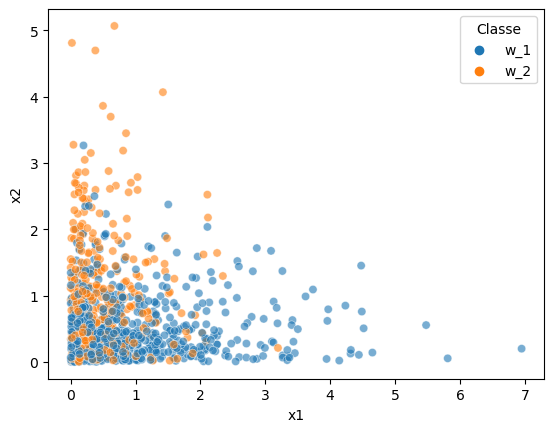

In [13]:
data = pd.DataFrame(dict(x1=X[:, 0], x2=X[:, 1], Classe=z))
sns.scatterplot(x="x1", y="x2", hue="Classe", data=data, alpha=.6)
plt.show()

In [14]:
def delta(row):
    x1, x2 = row
    cste = np.log((theta1 * theta2 * pi2) / (lambda1 * lambda2 * pi1))
    d = (theta1 - lambda1) * x1 + (theta2 - lambda2) * x2 - cste
    return "w_1" if d >= 0 else "w_2"

pred = np.apply_along_axis(delta, 1, X)

taux_Bayes = np.mean(pred != z)
taux_Bayes

0.311

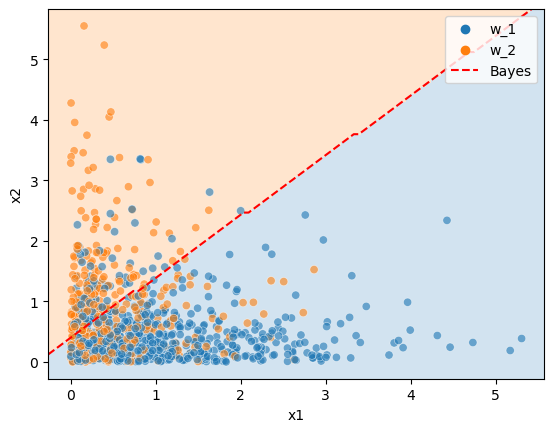

In [13]:
from TP07_K_plus_proches_voisins.src.utils import *

def predict(X):
    return np.apply_along_axis(delta, 1, X)

sns.scatterplot(x="x1", y="x2", hue="Classe", data=data, alpha=.6)
add_decision_boundary(predict, label="Bayes", model_classes=["w_1","w_2"])
plt.show()

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.33)

n_neighbors_list = np.unique(np.round(np.geomspace(1, 500, 100)).astype(int))
param_grid = {"n_neighbors": n_neighbors_list}

cls = KNeighborsClassifier()

search = GridSearchCV(cls, param_grid, scoring="accuracy", cv=10)
search.fit(X_train, z_train)

search.best_params_

{'n_neighbors': 111}

In [15]:
z_pred = search.predict(X_test)
miscls_KNN = 1 - accuracy_score(z_pred, z_test)
miscls_KNN

0.3242424242424242

In [16]:
z_pred = search.predict(X_train)
miscls_KNN_train = 1 - accuracy_score(z_train, z_pred)
miscls_KNN_train

0.29253731343283584

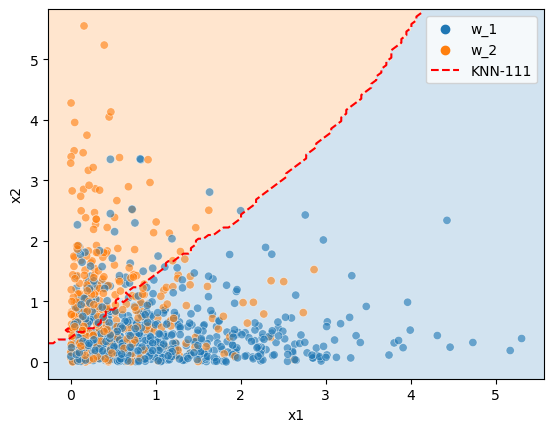

In [17]:
sns.scatterplot(x="x1", y="x2", hue="Classe", data=data, alpha=.6)
add_decision_boundary(search, label=f"KNN-{search.best_params_['n_neighbors']}")
plt.show()

# Calcul numérique de l’erreur de Bayes

In [5]:
from scipy.stats import expon
pi1 = 0.6
pi2 = 1 - pi1

lambda1 = 1
lambda2 = 2
theta1 = 2
theta2 = 1

def err_function(x1, x2):
    f1x1 = expon(scale=1/lambda1).pdf(x1)
    f1x2 = expon(scale=1/lambda2).pdf(x2)
    f2x1 = expon(scale=1/theta1).pdf(x1)
    f2x2 = expon(scale=1/theta2).pdf(x2)
    return min(pi1 * f1x1 * f1x2, pi2 * f2x1 * f2x2)

In [6]:
from scipy.integrate import dblquad
dblquad(err_function, 0, np.inf, 0, np.inf, epsabs=1e-3)

(0.31110590440142405, 0.0009941577509708348)

# Calcul numérique de l’erreur d’un classifieur

In [20]:
alpha = np.linspace(0, 1, 1000, endpoint=False)

In [21]:
rv = expon(scale=1/lambda1)
x1 = rv.ppf(alpha)
x2 = x1

In [22]:
f1x1 = expon(scale=1/lambda1)
f1x2 = expon(scale=1/lambda2)
X11, X12 = np.meshgrid(f1x1.pdf(x1), f1x2.pdf(x2))
f1 = pi1 * X11 * X12
f2x1 = expon(scale=1/theta1)
f2x2 = expon(scale=1/theta2)
X21, X22 = np.meshgrid(f2x1.pdf(x1), f2x2.pdf(x2))
f2 = pi2 * X21 * X22

In [23]:
X1, X2 = np.meshgrid(x1, x2)
x1x2 = np.column_stack((X1.ravel(), X2.ravel()))
Z = search.predict(x1x2).reshape(X1.shape)

In [24]:
err_KNN = np.where(Z == "w_1", f2, f1)
err_bayes = np.minimum(f1, f2)

In [25]:
from scipy.integrate import simps
simps(simps(err_bayes, x2), x1)

0.3111101803031248

In [26]:
simps(simps(err_KNN, x2), x1)

0.3115400064116635